In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from qiskit.visualization import plot_histogram
from ai_quantum.quantum.qaoa import QAOA
from ai_quantum.initialstates.dicke_initialstate import dicke_statevector
from return_cov import f_return_cov

from ai_quantum.ai_models.nn import NN_QAOA
import torch
import torch.optim as optim

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
%matplotlib inline
pd.options.mode.chained_assignment = None

In [ ]:
expected_value, cov_matrix = f_return_cov()

## Neural Networking model

In [ ]:
def f_loss(energies, sum_w):
    response = torch.mean((torch.exp(-sum_w)-torch.exp(-energies)).pow(2))
    return response

In [ ]:
def epoch_train(model, optimizer, batch_size, beta_temp=5):
    z = torch.ones(size=(batch_size, 1, latent_dim))
    w, energies, count, gamma, beta = model(z, beta_temp=beta_temp)
    sum_w = torch.sum(w, dim=1)
    df = pd.DataFrame(energies, columns=['energy'])
    
    optimizer.zero_grad()
    loss = f_loss(energies, sum_w)
    loss.backward()
    optimizer.step()
        
    return loss.item()

In [ ]:
q = 0.5 
B  = 2 
lamb= 0
qc_initial_state = dicke_statevector(len(expected_value), B)

latent_dim = 5
vocab_size = 100
batch_size = 5
epochs = 30
beta_temp = 1
depth = 10

In [6]:
nn_qaoa = NN_QAOA(depth, expected_value, cov_matrix, q, B, lamb, qc=qc_initial_state, mixture_layer='ring_mixer', vocab_size=vocab_size, latent_dim=latent_dim)
optimizer = optim.Adam(nn_qaoa.parameters(), lr=1e-10)

## Model Training

In [7]:
for i in range(1, epochs+1):
    loss_i = epoch_train(nn_qaoa, optimizer, batch_size, beta_temp=beta_temp)
    print(f"Epoch {i}, Loss: {loss_i:.2f}")

Epoch 1, Loss: 0.30
Epoch 2, Loss: 0.16
Epoch 3, Loss: 0.59
Epoch 4, Loss: 0.59
Epoch 5, Loss: 1.02
Epoch 6, Loss: 0.35
Epoch 7, Loss: 3.16
Epoch 8, Loss: 0.43
Epoch 9, Loss: 0.37
Epoch 10, Loss: 0.29
Epoch 11, Loss: 0.17
Epoch 12, Loss: 0.82
Epoch 13, Loss: 0.73
Epoch 14, Loss: 0.63
Epoch 15, Loss: 1.01
Epoch 16, Loss: 1.69
Epoch 17, Loss: 0.52
Epoch 18, Loss: 0.81
Epoch 19, Loss: 0.51
Epoch 20, Loss: 0.20
Epoch 21, Loss: 0.57
Epoch 22, Loss: 0.50
Epoch 23, Loss: 0.23
Epoch 24, Loss: 0.99
Epoch 25, Loss: 0.22
Epoch 26, Loss: 1.73
Epoch 27, Loss: 1.51
Epoch 28, Loss: 1.30
Epoch 29, Loss: 0.26
Epoch 30, Loss: 0.17


## Inference

In [8]:
z = torch.ones(size=(1, latent_dim))
nn_qaoa.eval()
with torch.no_grad():
    w, energy, count, gamma, beta = nn_qaoa(z, beta_temp=100000)
energy

tensor([0.3390], dtype=torch.float64)

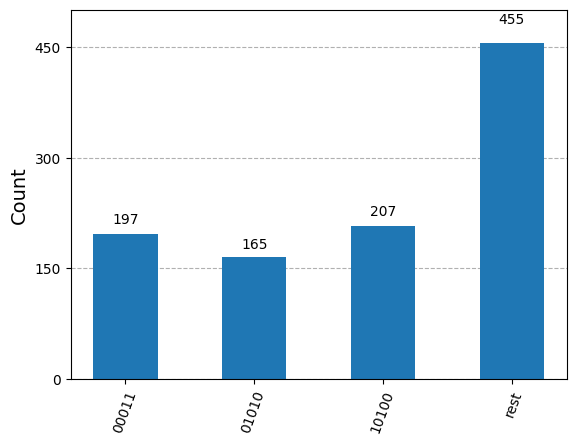

In [9]:
plot_histogram(count, number_to_keep=3)
plt.show()

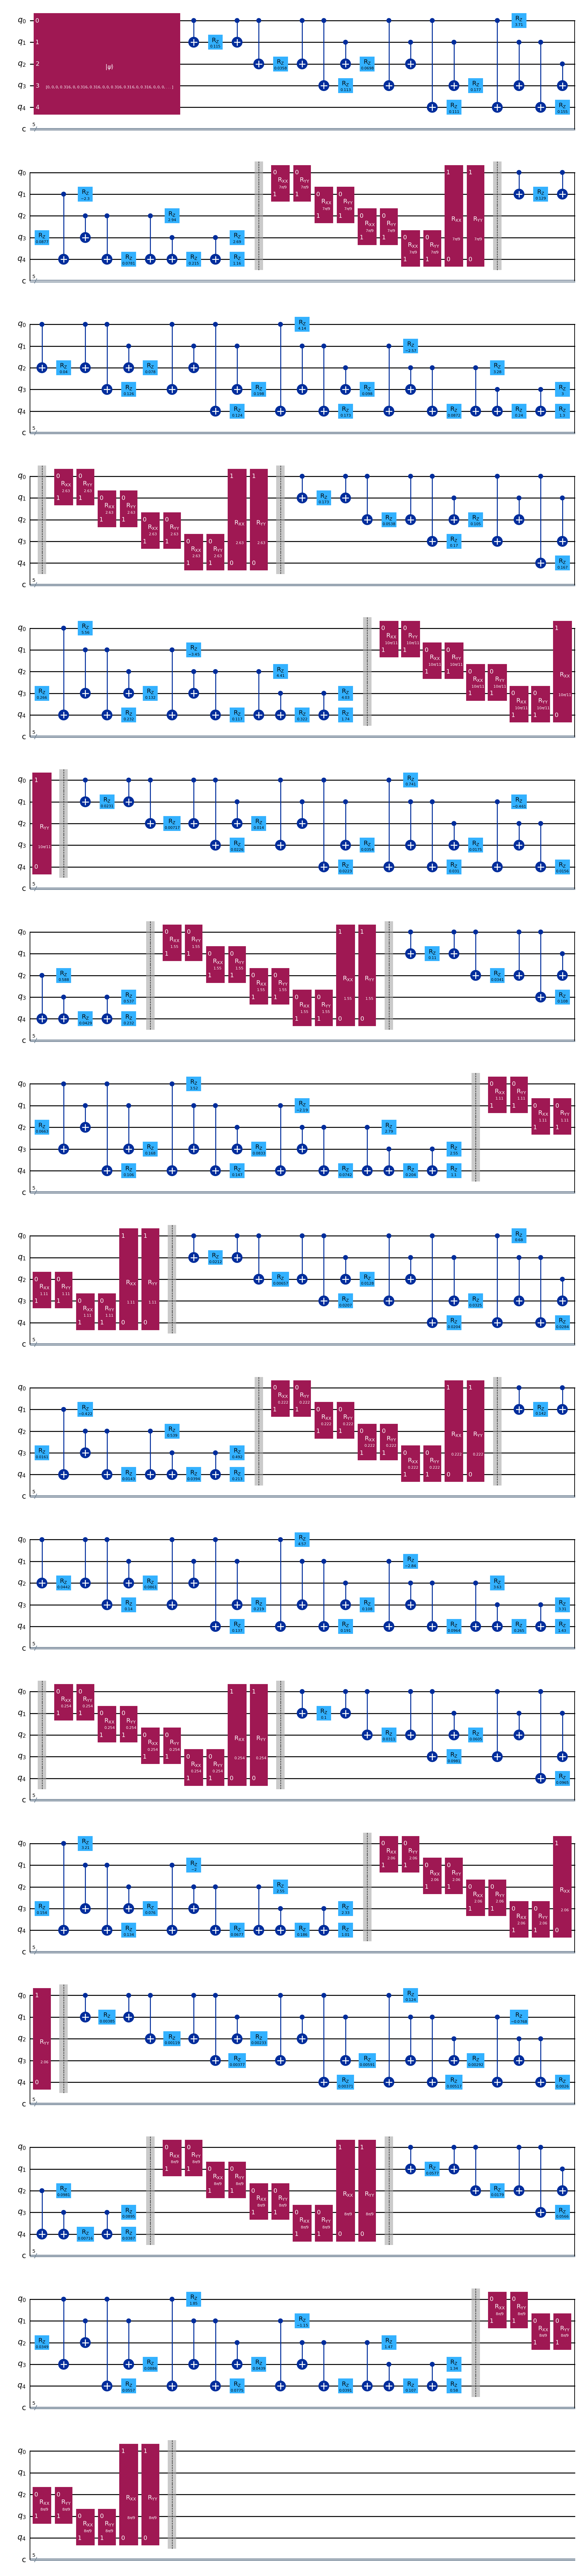

In [10]:
qaoa = QAOA(expected_value, cov_matrix, q, B, lamb, qc=qc_initial_state, mixture_layer='ring_mixer')
for i in range(len(gamma)):
    qaoa.add_layer(gamma[i], beta[i])
qaoa.draw()